# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## 1. Business Understanding

### Problem Statement

Befor we go deep into data, lets first understand what we are going to do in this project. 
As stated in the Introduction Part we are basically aiming to to answer two questions:
1. Discover the main drivers of offer effectiveness.
2. Explore if we can predict whether a user would take up an offer.

### Data Analysis and Modelling

We will discover the main drivers of effectiveness in **Data Analysis** part of this project and we will address the seccond point in **Modelling part**.

In **Data Anlysis** part we will do some analysis on startbuck customer on boarding trend, which age groups do more transactions in starbuck, income analysis of customer and gender based analysis of starbuck customers.

in **Feature Engineering** we will engineer our features of data so that it can be able to fit in our machine learning model.

We are going to use **Logistic Regression,Random Forest and XGBoost** machine learning models to predict whether a customer is going to avail the offer or not.

### Metrics

We are using two metrics to asses our models one is accuracy score and another is f1- score

Accuracy is a common metric for binary classifier. It takes into account both true positive and true negatives with equal weight.

      accuracy= (true_positive + True_Negative) / (Dataset_size)

F₁ score is a measure of a test's accuracy. It considers both the precision p and the recall r of the test to compute the score.

      f1score= 2x((precision*recall)/(precision+recall))
 
For calculating these metrics we are using scikit learn library.

In [1]:
'''
Note: Install Progressbar2 and XGBoost in your terminal to run the below code without any errors
To install XGBoost run this code in terminal "conda install -c conda-forge xgboost"

'''

import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import progressbar
import re

from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from time import time
import matplotlib.pyplot as plt

% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 2. Data Understanding

Lets understand and explore the data one by one.

### 2.1 Portfolio Data

This is the schema for portfolio data.
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [2]:
#First five rows of portfolio
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


So, portfolio is having 10 unique offers. Also, as we can observe channels column consist of nested list. Hence, we need to change into categorical variable. That we will do later in data processing part. Also, there is a quantative difference in columns for example difficulty is in dollar and durations is in days. Hence we need to do some featue scaling later.

In [3]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [4]:
#Types of offer available to users
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

We can see above there are 4 types of bogo offers, 4 types of discount and 2 types of informational but all offer is having a unique offer id. Our primary focus is going to be on bogo and discount since, informational is having only two type and there is a less chance that customer would respond to this offer.

### 2.2 Profile Data

This is the schema for porofile data.

* 0age (int) - age of the customer
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [5]:
#first five rows of profile data
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


We can see there are some null values in the data set and also in the age column there are some inconsistent values for example 118. Lets explore more

In [6]:
#Number of null values
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

Gender and income are having common null values which is a good thing. It seems like people who don't provide their income also not prefered to provide gender. Perhaps, these customers were not interested in surveys so they preferred to leave it as blank.

In [7]:
profile.shape

(17000, 5)

#### 2.2.1 Age

In [8]:
#Age Distribution
count_by_agegroup= profile.groupby(pd.cut(profile['age'] ,  np.arange(0, 118+10, 10)))['id'].count()
count_by_agegroup

age
(0, 10]          0
(10, 20]       340
(20, 30]      1365
(30, 40]      1597
(40, 50]      2391
(50, 60]      3590
(60, 70]      2910
(70, 80]      1646
(80, 90]       767
(90, 100]      214
(100, 110]       5
(110, 120]    2175
Name: id, dtype: int64

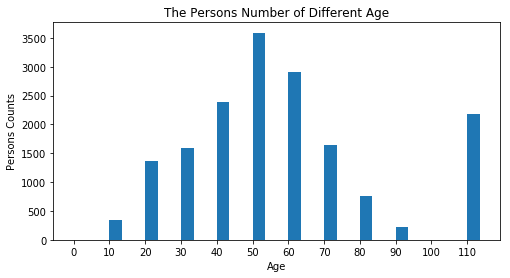

In [9]:
# Visualisation of age distribution

plt.figure(figsize=(8,4))
plt.bar(np.arange(0, 118, 10),count_by_agegroup,width=3.5, align='edge')
plt.xticks(np.arange(0, 118, 10))
plt.xlabel('Age')
plt.ylabel('Persons Counts')
plt.title('The Persons Number of Different Age')
plt.show()

Most of the customers lies in the age group of between 30 to 70 years.We can also notice, in the bar graph that age above 110 is outlier in our data.

#### 2.2.2 Gender

Text(0.5,1,'Gender Distribution')

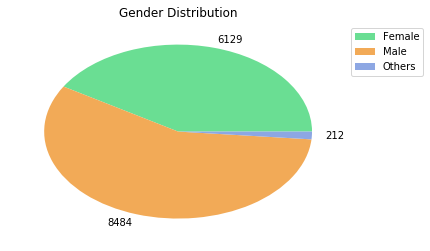

In [10]:
#Gender Distribution
group_by_gender= profile.groupby(profile['gender'])['gender'].count()
labels= ['Female','Male', 'Others']
plt.pie( group_by_gender,labels= group_by_gender, colors= ['#6ade93', '#f2aa57', '#8da7e3'])
plt.legend(labels, bbox_to_anchor=(1,1))
plt.title('Gender Distribution')

Number of Male customers are more than the female customer

#### 2.2.3 Income

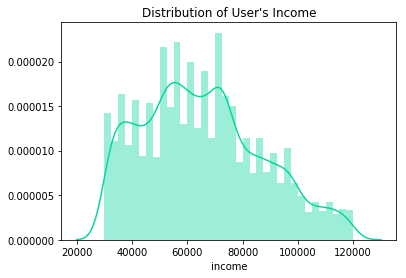

In [11]:
plt.figure()
plt.title('Distribution of User\'s Income')
sns.distplot(profile['income'].dropna(), color='#09d69f')
plt.show()

In [12]:
print('Mean Income: ', np.round(profile['income'].mean(), 2))
print('Median Income: ', np.round(profile['income'].median(), 2))

Mean Income:  65404.99
Median Income:  64000.0


We cannot see any outlier in the values of income. There are slight peaks in the distribution, probably because of 
people rounding up/down their income values when they report the income in the app. The graph is also skewed to right that means most of the customers belongs to average income bracket.

###  2.3 Transcript

* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [13]:
#First five rows of the data
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [14]:
# Standardize the id to join with the profile table
transcript = transcript.rename(columns={'person' : 'profile_id'})

In [15]:
# First five rows
transcript.head()

,event,profile_id,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [16]:
#Count of transaction and customer response against the offer
offer_response= transcript['event'].value_counts()
offer_response= pd.DataFrame(list(zip(offer_response.index, offer_response)),columns=['event', 'count'])
offer_response

,event,count
0,transaction,138953
1,offer received,76277
2,offer viewed,57725
3,offer completed,33579


So basically we have 4 categoriies  for the customer response against the offer
1. offer received
2. offer viewed
3. transaction
4. offer completed

Later we need to segregate the transaction data from transcript for the analysis.

In [17]:
#Shape of the data
transcript.shape

(306534, 4)

In [18]:
#Checking Null Values
transcript.isnull().sum()

event         0
profile_id    0
time          0
value         0
dtype: int64

Great we dont have any null values in this data. However, the data looks a bit more tricky, as it is ordered by time and has an event and value.

In [19]:
#Checking the unique number of customers
transcript['profile_id'].nunique()

17000

It's seems like the number of people in transcript data is same as the number of people in Demograhic data. This looks good.

In [20]:
#Computing the percentage of customer transaction and offer events
total_events = offer_response['count'].sum()

transaction_percentage = 100 * offer_response.iloc[0]['count'] / total_events
offer_percentage = 100 * offer_response.iloc[1:]['count'].sum() / total_events

print("Percentage of customer transaction events: %.1f %%" % (transaction_percentage ))
print("Percentage of customer offer events: %.1f %%" % (offer_percentage))

Percentage of customer transaction events: 45.3 %
Percentage of customer offer events: 54.7 %


From above result we can tell 45% of transcript dataset is related to customer purchase and 54 % of data is related to offers

## 3. Data Preprocessing

### 3.1 Portfolio Data:

1. First thing we need we need to do is Hot Encode the channels column.
2. We will also create the dummy column for offer_type. For this we will create a function that we can use later also  to create dummy variable. Since channels columns contain the data in list we will be not able to apply that fucntion to it.

In [21]:
# find all available channels
available_channels = []
for channel_list in portfolio['channels']:
    for channel in channel_list:
        if channel not in available_channels:
            available_channels.append(channel)

# one-hot encode channel
for channel in available_channels:
    portfolio[channel] = portfolio['channels'].apply(lambda x: 1 if channel in x else 0)
    
# drop channels column
portfolio.drop(['channels'], axis=1, inplace=True)

portfolio.head()

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


In [22]:
# One hot Encoded function

def one_hot_encoding(dataframe, column_list):
    
    '''INPUT- Dataframe and list which need to be encoded
       OUTPUT- Encoded catrgorical columns
    '''
    
    for column in column_list:
        column_dummies = pd.get_dummies(dataframe[column],prefix=column, prefix_sep='_',)
        dataframe = dataframe.drop(column, axis = 1)
        dataframe = dataframe.join(column_dummies)
    return dataframe

In [23]:
# Encodeing the offer_type
offer_type_col= ['offer_type']
portfolio= one_hot_encoding(portfolio, offer_type_col)

# Renaming the id column to offer_id so that it is easy to distinguish
portfolio.rename(columns={'id': 'offer_id'}, inplace= True)
portfolio.head()

,difficulty,duration,offer_id,reward,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,1,1,0,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,0,1,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,0,1,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,0,0,1,0,1,0


### 2.2 Profile Data

1. We need to convert the datatype of "became_member_on" column to datetime.
2. After converting to datetime we need to extract year and month and rename the column to year and month respectively.

In [24]:
# convert the datatype into datetime
profile["became_member_on"] = pd.to_datetime(profile.became_member_on.apply(str))
profile["became_member_year"] = profile.became_member_on.dt.year
profile["became_member_month"] = profile.became_member_on.dt.month
profile.head()

,age,became_member_on,gender,id,income,became_member_year,became_member_month
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,7
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN,2017,8


3. Now we will deal with the outlier of the profile data that is age. We will convert the age =118 to np.nan.
4. Perform one hot encoding to gender column so that it will help in data analysis part

In [25]:
#Replacing age outlier with np.nan
profile.loc[profile.age == 118, "age"] = np.nan

# profile: drop rows with no gender, income, age data
profile = profile.drop(profile[profile['gender'].isnull()].index)

#Renaming the column
profile.rename(columns={profile.columns.values[5]: 'became_member_year', profile.columns.values[6]: 'became_member_month',
                        'id':'customer_id' }, inplace= True)

#One Hot Encoding of Gender Column

gender_col= ['gender']
profile = one_hot_encoding(profile, gender_col)

#Remaing the newly created gender column
profile.rename(columns={'gender_M': 'Male', 'gender_F': 'Female', 'gender_O': 'Others'}, inplace= True)

profile.head()

,age,became_member_on,customer_id,income,became_member_year,became_member_month,Female,Male,Others
1,55.0,2017-07-15,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,1,0,0
3,75.0,2017-05-09,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,1,0,0
5,68.0,2018-04-26,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,0,1,0
8,65.0,2018-02-09,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,0,1,0
12,58.0,2017-11-11,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,0,1,0


### 2.3 Transcript Data

In [26]:
#Renaming the profile_id to customer_id so that it will be easy to map with demographic data

transcript.rename(columns={'profile_id': 'customer_id'}, inplace= True)
transcript.head()

,event,customer_id,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


Since 'value' column contains the data of offers and transactions in the form of dictionary, hence, we need to exctract the offer_id and transactions amount from the data  and need to store in seperate columns like offer id and transaction.

In [27]:
#Creating seperate columns for offer id and transaction amounts

def offer_id_col(value):
    '''
    INPUT- Column contains the value in dictionary form
    OUTPUT- return the values
    '''
    
    if list(value.keys())[0] in ['offer id', 'offer_id']:
        return list(value.values())[0]
    
def amount_col(value):
    if list(value.keys())[0] in ['amount']:
        return list(value.values())[0]
    
transcript['offer_id'] = transcript.value.apply(offer_id_col)
transcript['amount'] = transcript.value.apply(amount_col)

# change amount column type to float
transcript.amount.astype('float')

# drop value column
transcript.drop(columns=['value'], inplace=True)

In [28]:
transcript.head()

,event,customer_id,time,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [29]:
#Checking for the duplicate values
transcript[transcript.duplicated()].count()

event          397
customer_id    397
time           397
offer_id       397
amount           0
dtype: int64

In [30]:
#No of rows before deleting the duplicates
print(transcript.shape[0])

306534


Some person had completed the same offer twice  so we need to remove those duplicate values.

In [31]:
# droping the duplicate values, and reset the index
transcript.drop_duplicates(inplace=True)

transcript.reset_index(drop=True, inplace=True)

# No of rows after deleting the duplicates
print(transcript.shape[0])

306137


In [32]:
#drop transaction rows whose customer_id is not in profile:customer_id data
transcript = transcript[transcript.customer_id.isin(profile.customer_id)]

In [33]:
# Converting the time into day format
transcript['time'] = transcript['time']/ 24.0

#### 2.3.1 Creating Transaction DataFrame
Need to store transaction data in a seperate data frame for easy analysis.

In [34]:
#segregate offer and transaction data 

# extract transactions from transcript data
transaction_df = transcript[transcript.event=='transaction'].copy()
transaction_df.drop(columns=['offer_id', 'event'], inplace=True)
transaction_df.head()

,customer_id,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0.0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,34.56
12659,54890f68699049c2a04d415abc25e717,0.0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0.0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0.0,18.97


#### 2.3.2 Creating Offers DataFrame

Same thing we need to do with offers. We need to store the offer related data in a seperate dataframe.

In [35]:
# extract offer-related from transcript data
offers_df = transcript[transcript.event!='transaction'].copy()

# one-hot encode offer event
event_col= ['event']
offers_df= one_hot_encoding(offers_df, event_col)

#Renaming the columns
offers_df.rename(columns={'event_offer completed': 'completed', 'event_offer received' : 'received',
                          'event_offer viewed': 'viewed' }, inplace= True)

offers_df.drop(columns=['amount'], inplace=True)
offers_df.head()

,customer_id,time,offer_id,completed,received,viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
2,e2127556f4f64592b11af22de27a7932,0.0,2906b810c7d4411798c6938adc9daaa5,0,1,0
5,389bc3fa690240e798340f5a15918d5c,0.0,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0
7,2eeac8d8feae4a8cad5a6af0499a211d,0.0,3f207df678b143eea3cee63160fa8bed,0,1,0
8,aa4862eba776480b8bb9c68455b8c2e1,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0


## 3. Data Analysis

After cleaning the data it is important to do some data analysis to get some more insights from data and establish a relation between these data sets.

### 3.1 Profile Data

Before analysing the profile data lets recollect the some key points from Data Undersating :
1. Most of the customers lies in the middle age group that is between 30 to 70.
2. Male customers are more than the female customers.
3. The graph was skewed to right that means most of the customers belongs to average income bracket.

In [36]:
profile.head()

,age,became_member_on,customer_id,income,became_member_year,became_member_month,Female,Male,Others
1,55.0,2017-07-15,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,1,0,0
3,75.0,2017-05-09,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,1,0,0
5,68.0,2018-04-26,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,0,1,0
8,65.0,2018-02-09,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,0,1,0
12,58.0,2017-11-11,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,0,1,0


#### 3.1.1 Income Distribution vs Gender Distribution
Since we have created the dummy variable columns for gender column therefore, now we can drill down more into the data.
Firstly lets analyse the incomes of Male and Female.

In [37]:
#Average income of different Gender group
print('Male Average Income {}'.format(profile[(profile['Male']==1)]['income'].mean()))
print('Female Average Income {}'.format(profile[(profile['Female']==1)]['income'].mean()))
print('Others Average Income {}'.format(profile[(profile['Others']==1)]['income'].mean()))

Male Average Income 61194.60160301744
Female Average Income 71306.41213901126
Others Average Income 63287.735849056604


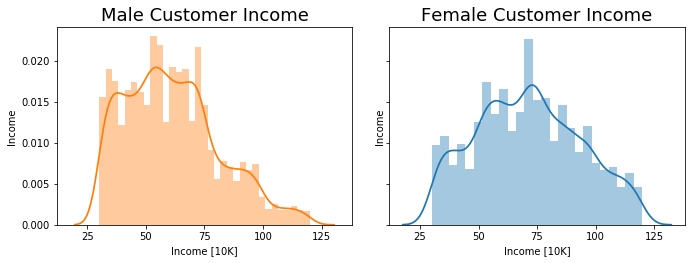

In [38]:
# extract male and female customers
male_customers = profile[profile['Male'] == 1]
female_customers = profile[profile['Female'] == 1]

# to be able to draw two subplots in a row
fig, ax = plt.subplots(figsize=(10, 4), nrows=1, ncols=2, sharex=True, sharey=True)

current_palette = sns.color_palette()
sns.set(font_scale=1.5)
sns.set_style('white')

# plot a male customers income distribution
plt.sca(ax[0])
sns.distplot(male_customers['income'] * 1E-3, color=current_palette[1])
plt.xlabel('Income [10K]')
plt.ylabel('Income')
plt.title('Male Customer Income')

# plot a female customers income distribution
plt.sca(ax[1])
sns.distplot(female_customers['income'] * 1E-3, color=current_palette[0])
plt.xlabel('Income [10K]')
plt.ylabel('Income')
plt.title('Female Customer Income')
plt.tight_layout()

Results suggest that the minimum and maximum income for both male and female customers are approximately the same. However, male customer income is slightly biased towards lower values compared to female customer income.

#### 3.1.2 Evaluate Membership Start Year Statistics

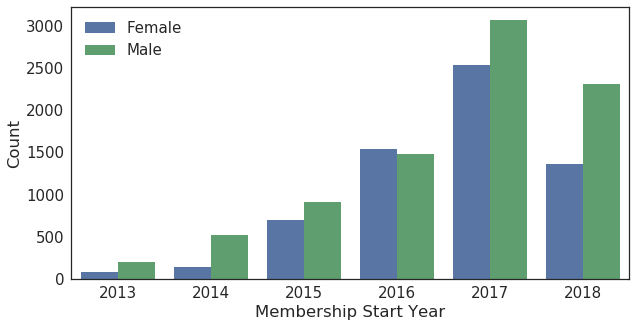

In [39]:
# groupby start_year and gender to plot a graph
membership_date = profile.groupby(['became_member_year', 'Male']).size()
membership_date = membership_date.reset_index()
membership_date.columns = ['became_member_year', 'Male',  'count']

# plot a bar graph for age distribution as a function of gender in membership program
plt.figure(figsize=(10, 5))
sns.barplot(x='became_member_year', y='count', hue='Male', data=membership_date)
l= plt.legend()
l.get_texts()[0].set_text('Female')
l.get_texts()[1].set_text('Male')
plt.xlabel('Membership Start Year')
plt.ylabel('Count');

**Observations**
1. The result suggest that some intresting facts here. We can see that there is an increase in the number of customers from year 2017.
2. There are more increase in numbers of Male as compared to Female. One fact we already know from Data Undersatnding that there are more number of male customers as compared to 

#### 3.1.3 Evaluating Age and Gender Statistics

We will analyse the behavior of Male Female transaction habbits.

In [40]:
#Age vs Gender Transaction
agegroup_gender= profile.groupby(pd.cut(profile['age'] ,  np.arange(0, 118+10, 10)))['Male', 'Female'].sum()
agegroup_gender

,Male,Female
age,,
"(0, 10]",0.0,0.0
"(10, 20]",256.0,80.0
"(20, 30]",953.0,398.0
"(30, 40]",1049.0,522.0
"(40, 50]",1457.0,898.0
"(50, 60]",1953.0,1574.0
"(60, 70]",1549.0,1327.0
"(70, 80]",852.0,771.0
"(80, 90]",334.0,423.0


**Observations of Profile Analysis**

1. From the Data understanding part we can say that high-income users are not the main users; but the low-income users and the medium income users have the most transaction amount.
2. Whereas the high-level females transaction amount is higher than the high-level males.
3. Above Analysis also suggest that there is not much difference in Male and Female income.However, male customer income is slightly biased towards lower values compared to female customer income.
4. There is a increase in transaction after year 2016.
5. We noticed more noticible spike in male transaction as compared to female transaction.

### 3.2 Transaction Data

Before analysing the transaction data lets note down the point that we already know from Data understanding.

1. The Transcript data was divided into two parts. First is transaction which comprises 45% of the data set and seccond part is offers which comprises 54% of the the dataset.
2. We already segregated this data in two parts in **Data Processing**.

To analyse transaction data first we need to combine transaction data with profile data, portfolio data an offers data.

For Each customer we need to apply following algorithm:

1. Iterate over each offer a customer receives
2. Initialize the current offer id
3. Look-up a description of the current offer
4. Initialize the time period when an offer is valid
5. Initialize a Boolean array that select customer transactions that fall within the valid offer time window
6. Initialize a Boolean array that selects a description of when a customer completes an offer (this array may not contain any True values)
7. Initialize a Boolean array that selects a description of when a customer views an offer (this array may not contain any True values)
8. Determine whether the current offer was successful
9. Select customer transactions that occurred within the current offer valid time window
10. Initialize a dictionary that describes the current customer offer
11. Update a list of dictionaries that describes the effectiveness of offers to a specific customer

Once all customer transactions have been evaluated, convert the resulting list of dictionaries into a pandas DataFrame.

#### 3.2.1 Combining Data

In [41]:
def combine_data(profile, portfolio, offers_df, transaction_df):
    
    '''
    INPUT- 4 Data frame which needs to be combine
    OUTPUT- Combine 4 dataframe and gives output on the basis viewed offer is completed or not in the given time frame.
    '''
    
    data = []
    customer_ids = offers_df['customer_id'].unique()
    
    widgets=[
        ' [', progressbar.Timer(), '] ',
        progressbar.Bar(),
        ' (', progressbar.ETA(), ') ',
    ]
    
    # loop through all customer ids in offers_df
    for cus in progressbar.progressbar(range(len(customer_ids)), widgets=widgets):
        
        # get customer id from the list
        cust_id = customer_ids[cus]
        
        # extract customer profile from profile data
        customer = profile[profile['customer_id']==cust_id]
        
        # extract offers associated with the customer from offers_df
        customer_offer_data = offers_df[offers_df['customer_id']==cust_id]
        
        # extract transactions associated with the customer from transactions_df
        customer_transaction_data = transaction_df[transaction_df['customer_id']==cust_id]
        
        # extract received, completed, viewed offer data from customer offers
        offer_received_data = customer_offer_data[customer_offer_data['received'] == 1]
        offer_completed_data = customer_offer_data[customer_offer_data['completed'] == 1]
        offer_viewed_data = customer_offer_data[customer_offer_data['viewed'] == 1]
        
        rows = []
        # loop through each received offer
        for i in range(offer_received_data.shape[0]):
            
            # fetch an offer id 
            offer_id = offer_received_data.iloc[i]['offer_id']
            
            # extract offer row from portfolio
            offer_row = portfolio.loc[portfolio['offer_id'] == offer_id]
            
            # extract duration days of an offer from offer row
            duration_days = offer_row['duration'].values[0]
            
            # initialize start and end time of an offer
            start_time = offer_received_data.iloc[i]['time']
            end_time = start_time + duration_days
        
            # seggregate offers completed within end date
            off_completed_withintime = np.logical_and(
                offer_completed_data['time'] >= start_time, offer_completed_data['time'] <= end_time)
            
            # seggregate offers viewed within end date
            off_viewed_withintime = np.logical_and(
                offer_viewed_data['time'] >= start_time, offer_viewed_data['time'] <=end_time)

            # flag offer_successful to 1 if an offer is viewed and completed within end time else to 0
            offer_successful = off_completed_withintime.sum() > 0 and off_viewed_withintime.sum() > 0
            
            # extract transactions occured within time
            transaction_withintime = np.logical_and(
                customer_transaction_data['time'] >= start_time, customer_transaction_data['time'] <= end_time)
        
            transaction_data = customer_transaction_data[transaction_withintime]
            
            # total amount spent by a customer from given offers
            transaction_total_amount = transaction_data['amount'].sum()
            
            row = {
                'offer_id': offer_id,
                'customer_id': cust_id,
                'time': start_time,
                'total_amount': transaction_total_amount,
                'offer_successful': int(offer_successful),
            }
                
            row.update(offer_row.iloc[0,0:].to_dict())

            row.update(customer.iloc[0,:].to_dict())

            rows.append(row)
        
        data.extend(rows)
    
    data = pd.DataFrame(data)
    return data

In [42]:
data = combine_data(profile, portfolio, offers_df, transaction_df)

 [Elapsed Time: 0:14:18] |##################################| (Time:  0:14:18) 


In [43]:
data.head()

,Female,Male,Others,age,became_member_month,became_member_on,became_member_year,customer_id,difficulty,duration,...,offer_id,offer_successful,offer_type_bogo,offer_type_discount,offer_type_informational,reward,social,time,total_amount,web
0,1,0,0,75.0,5,2017-05-09,2017,78afa995795e4d85b5d9ceeca43f5fef,5,7,...,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,0,5,0,0.0,37.67,1
1,1,0,0,75.0,5,2017-05-09,2017,78afa995795e4d85b5d9ceeca43f5fef,0,3,...,5a8bc65990b245e5a138643cd4eb9837,0,0,0,1,0,1,7.0,49.39,0
2,1,0,0,75.0,5,2017-05-09,2017,78afa995795e4d85b5d9ceeca43f5fef,10,7,...,ae264e3637204a6fb9bb56bc8210ddfd,1,1,0,0,10,1,17.0,48.28,0
3,1,0,0,75.0,5,2017-05-09,2017,78afa995795e4d85b5d9ceeca43f5fef,5,5,...,f19421c1d4aa40978ebb69ca19b0e20d,1,1,0,0,5,1,21.0,48.28,1
4,0,1,0,68.0,4,2018-04-26,2018,e2127556f4f64592b11af22de27a7932,10,7,...,2906b810c7d4411798c6938adc9daaa5,0,0,1,0,2,0,0.0,0.00,1


In [44]:
#Count of Succesfull
data.offer_successful.value_counts()

0    35136
1    31365
Name: offer_successful, dtype: int64

In [45]:
#Columns in our data
data.columns

Index(['Female', 'Male', 'Others', 'age', 'became_member_month',
       'became_member_on', 'became_member_year', 'customer_id', 'difficulty',
       'duration', 'email', 'income', 'mobile', 'offer_id', 'offer_successful',
       'offer_type_bogo', 'offer_type_discount', 'offer_type_informational',
       'reward', 'social', 'time', 'total_amount', 'web'],
      dtype='object')

#### 3.2.2 Loading and Reading the new data

After cleaning and combining the data it is better we can save it to csv file for better data handling

In [46]:
#expoting combied data to csv file
data.to_csv('transaction_offer_analysis.csv', index=False)

In [47]:
#Reading and storing the data from csv file
data_df= pd.read_csv('transaction_offer_analysis.csv')

#### 3.2.3 Analysing the Gender vs succesfull offer

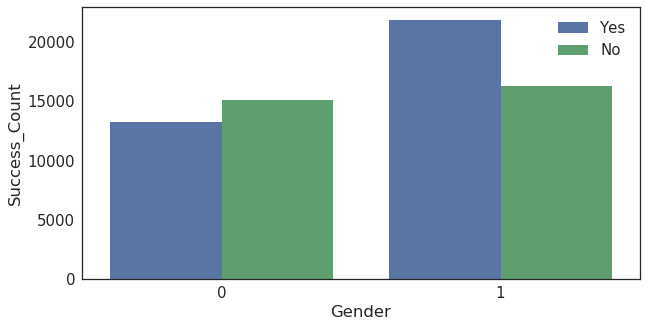

In [48]:
gender_size= data_df.groupby(['Male','offer_successful']).size()
gender_size= gender_size.reset_index()
gender_size.columns = ['Male','offer_successful',  'count']

# plot a bar graph for age distribution as a function of gender in membership program
plt.figure(figsize=(10, 5))
sns.barplot(x='Male', y='count', hue='offer_successful', data=gender_size)
l= plt.legend()
l.get_texts()[0].set_text('Yes')
l.get_texts()[1].set_text('No')
plt.xlabel('Gender')
plt.ylabel('Success_Count');

Here '0' is Female and '1' is male. From the graph we can say that more male are completeing the offers as compared to female.

#### 3.2.4 Analysing the Membership start year vs succesfull offer

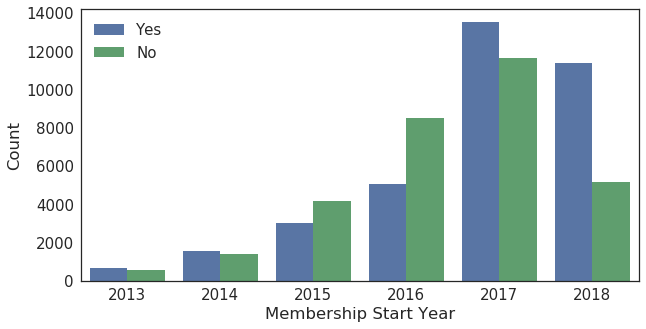

In [49]:
# groupby start_year and gender to plot a graph
membership_date = data_df.groupby(['became_member_year', 'offer_successful']).size()
membership_date = membership_date.reset_index()
membership_date.columns = ['became_member_year', 'offer_successful',  'count']

# plot a bar graph for age distribution as a function of gender in membership program
plt.figure(figsize=(10, 5))
sns.barplot(x='became_member_year', y='count', hue='offer_successful', data=membership_date)
l= plt.legend()
l.get_texts()[0].set_text('Yes')
l.get_texts()[1].set_text('No')
plt.xlabel('Membership Start Year')
plt.ylabel('Count');

The above graph is quite interesting . Before 2017, no of non completed offers is more than the no of offers completed. However, from 2017 the scenario is completely change. Perhaps, company has change their marketing startegy.

#### 3.2.5 Analyze Offer Statistics

In [50]:
#Calculating success percent of offers

def success_percent_of_offers():
    
    '''
    INPUT- Take dataframe as an input
    OUTPUT- give a column of success percentage of offer that is completed by the customers
    '''
    successful_offer_count = data[['offer_id', 'offer_successful', 'Male','Female']].groupby(
        'offer_id').sum().reset_index()

    offer_count = data['offer_id'].value_counts()

    offer_count = pd.DataFrame(list(zip(offer_count.index.values,
                                        offer_count.values)),
                               columns=['offer_id', 'count'])

    successful_offer_count = successful_offer_count.sort_values('offer_id')

    offer_count = offer_count.sort_values('offer_id')

    percent_success = pd.merge(offer_count, successful_offer_count, on="offer_id")

    percent_success['percent_success'] = (100 * percent_success['offer_successful'] / percent_success['count'])

    percent_success = pd.merge(percent_success, portfolio, on="offer_id")

    percent_success = percent_success.drop(columns=['offer_successful'])

    percent_success = percent_success.sort_values('percent_success', ascending=False)

    return percent_success.reset_index(drop=True)

In [51]:
#Calling the function
success_percent = success_percent_of_offers()
success_percent

,offer_id,count,Male,Female,percent_success,difficulty,duration,reward,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational
0,fafdcd668e3743c1bb461111dcafc2a4,6652,3868,2696,75.285628,10,10,2,1,1,1,1,0,1,0
1,2298d6c36e964ae4a3e7e9706d1fb8c2,6655,3845,2718,72.742299,7,7,3,1,1,1,1,0,1,0
2,f19421c1d4aa40978ebb69ca19b0e20d,6576,3767,2721,61.618005,5,5,5,1,1,1,1,1,0,0
3,ae264e3637204a6fb9bb56bc8210ddfd,6683,3840,2750,54.646117,10,7,10,1,1,1,0,1,0,0
4,4d5c57ea9a6940dd891ad53e9dbe8da0,6593,3784,2737,51.721523,10,5,10,1,1,1,1,1,0,0
5,9b98b8c7a33c4b65b9aebfe6a799e6d9,6685,3817,2767,48.287210,5,7,5,1,1,0,1,1,0,0
6,2906b810c7d4411798c6938adc9daaa5,6631,3815,2728,47.730357,10,7,2,1,1,0,1,0,1,0
7,0b1e1539f2cc45b7b9fa7c272da2e1d7,6726,3826,2801,45.762712,20,10,5,1,0,0,1,0,1,0
8,3f207df678b143eea3cee63160fa8bed,6657,3812,2749,7.721196,0,4,0,1,1,0,1,0,0,1
9,5a8bc65990b245e5a138643cd4eb9837,6643,3755,2789,6.277284,0,3,0,1,1,1,0,0,0,1


If we notice email column is having only value 1 which is kind of a bizzrare. We can say its an inconsistent data. Also from informational column we come to know that only two types of offer has been sent to the customers that is also not very important in predicting the results.

#### 3.2.6 visual representation of offer statics
We will try to answe below questions:
* How many customers were provided with the offer?
* Percentage of succesful offers completed by the customers

Text(0,0.5,'Success percentage')

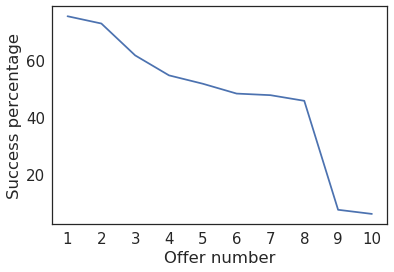

In [52]:
#Success Percentage vs offer number

plt.plot(success_percent.index + 1, success_percent['percent_success'])
plt.xticks(np.arange(0,10) + 1)
plt.xlabel('Offer number')
plt.ylabel('Success percentage')

#### 3.2.7 Heat Map for corealtion between varables

From this heat map we can also answer the first question of Business Undersatanding part that is:
1. Discover the main drivers of offer effectiveness.

From the heat map we can say that the main drivers which influence the customer to whether to do the transaction or not are

* Type of offer- Whether its a bogo, discount or informational.
* Duration- Time given to avail the offer
* Reward- How much benefit they can avail.
* Difficulty

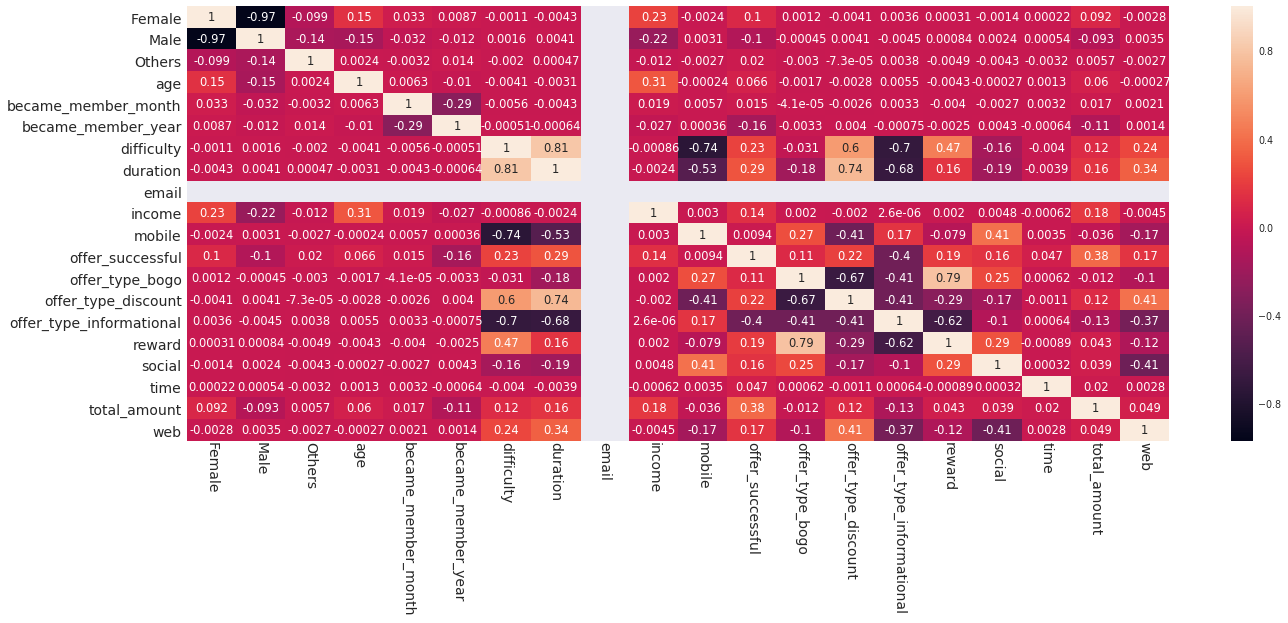

In [53]:
with sns.axes_style("dark"), sns.plotting_context("paper", font_scale=1.2):
    plt.figure(figsize=(22, 8))
    plt.tight_layout()
    ax = plt.subplot()
    sns.heatmap(data_df.select_dtypes(exclude=["object"]).corr(), annot=True, ax=ax)

    ax.tick_params(labelsize=14)
    ax.tick_params(axis="x", rotation=270, pad=0)

From the heat we can observe that the feature difficulty is highly corellated to feature duration. It seems like it also a major driver to predict our result.

**Observations**

1. These results suggest that distribution of offers in the simulated Starbucks mobile application data is approximately uniform. They also imply that the percentage of an offer's success ranges from ~ 6% to 75%, with the two least successful offers being informational.
2. Also all 10 offers distributed almost equally between customers.
3. From above observation we caome to know that informational column have only two types of offer that has been sent to the customers.

## Feature Engineering

After completing the data analysis part we need to do some feature engineering.
1. We need to make sure all the variable are in float or in int.
2. Need to change categorical variable to dummy columns.
3. To avoid dummy trap we need to drop 1 column each for every newly dummy column craeted.
4. Our Data is not scaled or normalised for example age column or income column they are having high value as respect to other dummy variable column. However, as mentioned in Business Understaning part we are going to use Linear Regression and Random Forrest which does not require feature scaling.

In [54]:
#Encoding Categorical columns
data_df2= data_df.copy()
encode_col= ['offer_id', 'became_member_year']
data_df2 = one_hot_encoding(data_df2,encode_col )

In [55]:
# We need to change the order of feature so that it is easy to split later
column_ordering = ['offer_successful']
column_ordering.extend([elem for elem in data_df2.columns if elem not in column_ordering])

data_df2 = data_df2[column_ordering]
data_df2.head()

,offer_successful,Female,Male,Others,age,became_member_month,became_member_on,customer_id,difficulty,duration,...,offer_id_9b98b8c7a33c4b65b9aebfe6a799e6d9,offer_id_ae264e3637204a6fb9bb56bc8210ddfd,offer_id_f19421c1d4aa40978ebb69ca19b0e20d,offer_id_fafdcd668e3743c1bb461111dcafc2a4,became_member_year_2013,became_member_year_2014,became_member_year_2015,became_member_year_2016,became_member_year_2017,became_member_year_2018
0,1,1,0,0,75.0,5,2017-05-09,78afa995795e4d85b5d9ceeca43f5fef,5,7,...,1,0,0,0,0,0,0,0,1,0
1,0,1,0,0,75.0,5,2017-05-09,78afa995795e4d85b5d9ceeca43f5fef,0,3,...,0,0,0,0,0,0,0,0,1,0
2,1,1,0,0,75.0,5,2017-05-09,78afa995795e4d85b5d9ceeca43f5fef,10,7,...,0,1,0,0,0,0,0,0,1,0
3,1,1,0,0,75.0,5,2017-05-09,78afa995795e4d85b5d9ceeca43f5fef,5,5,...,0,0,1,0,0,0,0,0,1,0
4,0,0,1,0,68.0,4,2018-04-26,e2127556f4f64592b11af22de27a7932,10,7,...,0,0,0,0,0,0,0,0,0,1


We need to drop unncessary columns first and last column of every dummy column to avaoid dummy variable trap.

1. We know that the feature email is imbalance data, hence we need to drop this feature.
2. We also need to drop customer id since it will not help in prediction same goes for time.
3. Since difficulty is high relation with the duration hence we need to drop difficulty column.
4. We will also drop information column since it has only type of offers.
5. Atlast we will drop the last column of each dummy variable.

In [56]:
#Droping columns unnecessary columns

data_df2= data_df2.drop(columns=['email', 'customer_id', 'time', 'offer_type_informational', 
                                'Others','became_member_on','offer_id_5a8bc65990b245e5a138643cd4eb9837',
                                'became_member_year_2014' ], axis= 1)
                               
data_df2.head()

,offer_successful,Female,Male,age,became_member_month,difficulty,duration,income,mobile,offer_type_bogo,...,offer_id_4d5c57ea9a6940dd891ad53e9dbe8da0,offer_id_9b98b8c7a33c4b65b9aebfe6a799e6d9,offer_id_ae264e3637204a6fb9bb56bc8210ddfd,offer_id_f19421c1d4aa40978ebb69ca19b0e20d,offer_id_fafdcd668e3743c1bb461111dcafc2a4,became_member_year_2013,became_member_year_2015,became_member_year_2016,became_member_year_2017,became_member_year_2018
0,1,1,0,75.0,5,5,7,100000.0,1,1,...,0,1,0,0,0,0,0,0,1,0
1,0,1,0,75.0,5,0,3,100000.0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,1,1,0,75.0,5,10,7,100000.0,1,1,...,0,0,1,0,0,0,0,0,1,0
3,1,1,0,75.0,5,5,5,100000.0,1,1,...,0,0,0,1,0,0,0,0,1,0
4,0,0,1,68.0,4,10,7,70000.0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [57]:
# Review the remaining object columns
data_df2.select_dtypes(include=['object']).columns

Index([], dtype='object')

Hence, we dont have any feature with data type object. We are good to go to build our model.

## 5. Building Model

### 5.1 Splitting the data into training and test set

To create our machine learning model first we need to split our data ino Training set and Test set.

In [58]:
# factors/features that influence the label variable
X = data_df2.iloc[:, 1:] 

# label variable to predict
y= data_df2.iloc[:, 0]

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.3, random_state=56)

### 5.2 valuate Naive Predictor Performance
First lets build a basic machine learning model to predict the result and what it's accuracy.

In [59]:
naive_predictor_accuracy = accuracy_score(y_train, np.ones(len(y_train)))
naive_predictor_f1score = f1_score(y_train, np.ones(len(y_train)))

print("Naive predictor accuracy: %.3f" % (naive_predictor_accuracy))
print("Naive predictor f1-score: %.3f" % (naive_predictor_f1score))

Naive predictor accuracy: 0.472
Naive predictor f1-score: 0.641


As we can see above the accuracy score and f1  score is quite low. We will try improve the score by using different models

## 5.3 Building Logistic Regression Model
1. Perform random search of model hyperparameter space
2. Evaluating our model

In [60]:
scorer = make_scorer(fbeta_score, beta=0.5)

# instantiate a logistic regression classifer object
logistic_clf = LogisticRegression(random_state=42, solver='liblinear')

# construct a params dict to tune the model
grid_params = {
    'penalty': ['l2'],
    'C': np.logspace(0, 4)}

logistic_random = RandomizedSearchCV(
                                    estimator = logistic_clf, param_distributions = grid_params, 
                                    scoring='roc_auc', n_iter = 3, cv = 10, verbose=2, 
                                    random_state=62, n_jobs = -1)

# fit train data to the model
logistic_random.fit(X_train, y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] penalty=l2, C=1526.41796718 .....................................
[CV] ...................... penalty=l2, C=1526.41796718, total=   1.1s
[CV] penalty=l2, C=1526.41796718 .....................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] ...................... penalty=l2, C=1526.41796718, total=   1.0s
[CV] penalty=l2, C=1526.41796718 .....................................
[CV] ...................... penalty=l2, C=1526.41796718, total=   0.9s
[CV] penalty=l2, C=1526.41796718 .....................................
[CV] ...................... penalty=l2, C=1526.41796718, total=   0.9s
[CV] penalty=l2, C=1526.41796718 .....................................
[CV] ...................... penalty=l2, C=1526.41796718, total=   0.9s
[CV] penalty=l2, C=1526.41796718 .....................................
[CV] ...................... penalty=l2, C=1526.41796718, total=   0.9s
[CV] penalty=l2, C=1526.41796718 .....................................
[CV] ...................... penalty=l2, C=1526.41796718, total=   1.0s
[CV] penalty=l2, C=1526.41796718 .....................................
[CV] ...................... penalty=l2, C=1526.41796718, total=   1.1s
[CV] penalty=l2, C=1526.41796718 .....................................
[CV] .

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   30.2s finished


RandomizedSearchCV(cv=10, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=3, n_jobs=-1,
          param_distributions={'penalty': ['l2'], 'C': array([  1.00000e+00,   1.20679e+00,   1.45635e+00,   1.75751e+00,
         2.12095e+00,   2.55955e+00,   3.08884e+00,   3.72759e+00,
         4.49843e+00,   5.42868e+00,   6.55129e+00,   7.90604e+00,
         9.54095e+00,   1.15140e+01,   1.38950e+01,   ...    3.90694e+03,   4.71487e+03,   5.68987e+03,   6.86649e+03,
         8.28643e+03,   1.00000e+04])},
          pre_dispatch='2*n_jobs', random_state=62, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=2)

### 5.3.1 Evaluating train data performance

In [61]:
def evaluating_model(clf, X_train, y_train):
    
    '''INPUT: Classifier and training data set
       OUTUT: Accuracy and f1 score
    '''
    
    class_name = re.sub("[<>']", '', str(clf.__class__))
    class_name = class_name.split(' ')[1]
    class_name = class_name.split('.')[-1]

    y_pred_rf = clf.predict(X_train)

    clf_accuracy = accuracy_score(y_train, y_pred_rf)
    clf_f1_score = f1_score(y_train, y_pred_rf)
    
    print("%s model accuracy: %.3f" % (class_name, clf_accuracy))
    print("%s model f1-score: %.3f" % (class_name, clf_f1_score))
    
    return clf_accuracy, clf_f1_score

In [62]:
# evaluate logistic regression model's performance
evaluating_model(logistic_random, X_train, y_train)

RandomizedSearchCV model accuracy: 0.873
RandomizedSearchCV model f1-score: 0.861


(0.87349087003222337, 0.86122958738836397)

### 5.3.2 Evaluating test data performance

In [63]:
evaluating_model(logistic_random, X_test, y_test)

RandomizedSearchCV model accuracy: 0.870
RandomizedSearchCV model f1-score: 0.857


(0.87003157736454317, 0.85663736385249067)

### 5.4 Building Random Forest Model
1. Perform random search of model hyperparameter space
2. Evaluating our model

In [64]:
# instantiate a random forest classifier obj
forest_clf = RandomForestClassifier(random_state=62)


# Create the random grid
grid_params = {'n_estimators': [10, 50, 100], #number of trees in the ensemble.
               'max_features': ['auto', 'sqrt', 'log2'], #max number of feature consider while splitting the node
               'min_samples_split': [2,4,8], #min number os samples stored in the lesf
               'min_samples_leaf': [1,2,4], #min sample required to split nodes
               'max_depth':[3,5,8] , #max number of level in each tree
               'criterion': ['gini']} #used to asses the quality of a split

# tune the classifer
forest_random = RandomizedSearchCV(estimator = forest_clf,
                               param_distributions = grid_params,
                               n_iter = 100,
                               scoring='roc_auc',
                               cv = 3,
                               n_jobs = -1,
                               verbose=2,
                               random_state=62
                               )

# fit train data to the classifier
forest_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=50, min_samples_split=8, min_samples_leaf=4, max_features=sqrt, max_depth=3, criterion=gini 
[CV]  n_estimators=50, min_samples_split=8, min_samples_leaf=4, max_features=sqrt, max_depth=3, criterion=gini, total=   0.7s
[CV] n_estimators=50, min_samples_split=8, min_samples_leaf=4, max_features=sqrt, max_depth=3, criterion=gini 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=50, min_samples_split=8, min_samples_leaf=4, max_features=sqrt, max_depth=3, criterion=gini, total=   0.7s
[CV] n_estimators=50, min_samples_split=8, min_samples_leaf=4, max_features=sqrt, max_depth=3, criterion=gini 
[CV]  n_estimators=50, min_samples_split=8, min_samples_leaf=4, max_features=sqrt, max_depth=3, criterion=gini, total=   0.7s
[CV] n_estimators=50, min_samples_split=4, min_samples_leaf=1, max_features=auto, max_depth=5, criterion=gini 
[CV]  n_estimators=50, min_samples_split=4, min_samples_leaf=1, max_features=auto, max_depth=5, criterion=gini, total=   0.9s
[CV] n_estimators=50, min_samples_split=4, min_samples_leaf=1, max_features=auto, max_depth=5, criterion=gini 
[CV]  n_estimators=50, min_samples_split=4, min_samples_leaf=1, max_features=auto, max_depth=5, criterion=gini, total=   0.9s
[CV] n_estimators=50, min_samples_split=4, min_samples_leaf=1, max_features=auto, max_depth=5, criterion=gini 
[CV]  n_estimators=50, min_samples_split=4, min_samp

[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=3, criterion=gini, total=   0.7s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=3, criterion=gini 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=3, criterion=gini, total=   0.7s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=3, criterion=gini 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=3, criterion=gini, total=   0.7s
[CV] n_estimators=100, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=5, criterion=gini 
[CV]  n_estimators=100, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=5, criterion=gini, total=   1.8s
[CV] n_estimators=100, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=5, criterion=gini 
[CV]  n_estimators=100, min_samples_split=4, min_

[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=8, criterion=gini, total=   2.6s
[CV] n_estimators=100, min_samples_split=8, min_samples_leaf=4, max_features=auto, max_depth=3, criterion=gini 
[CV]  n_estimators=100, min_samples_split=8, min_samples_leaf=4, max_features=auto, max_depth=3, criterion=gini, total=   1.3s
[CV] n_estimators=100, min_samples_split=8, min_samples_leaf=4, max_features=auto, max_depth=3, criterion=gini 
[CV]  n_estimators=100, min_samples_split=8, min_samples_leaf=4, max_features=auto, max_depth=3, criterion=gini, total=   1.3s
[CV] n_estimators=100, min_samples_split=8, min_samples_leaf=4, max_features=auto, max_depth=3, criterion=gini 
[CV]  n_estimators=100, min_samples_split=8, min_samples_leaf=4, max_features=auto, max_depth=3, criterion=gini, total=   1.3s
[CV] n_estimators=10, min_samples_split=8, min_samples_leaf=2, max_features=auto, max_depth=5, criterion=gini 
[CV]  n_estimators=10, min_samples_split=8, m

[CV]  n_estimators=10, min_samples_split=8, min_samples_leaf=1, max_features=log2, max_depth=3, criterion=gini, total=   0.1s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=3, criterion=gini 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=3, criterion=gini, total=   0.6s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=3, criterion=gini 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=3, criterion=gini, total=   0.6s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=3, criterion=gini 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=3, criterion=gini, total=   0.6s
[CV] n_estimators=50, min_samples_split=8, min_samples_leaf=1, max_features=auto, max_depth=8, criterion=gini 
[CV]  n_estimators=50, min_samples_split=8, min_samp

[CV]  n_estimators=100, min_samples_split=4, min_samples_leaf=4, max_features=log2, max_depth=3, criterion=gini, total=   1.2s
[CV] n_estimators=100, min_samples_split=4, min_samples_leaf=4, max_features=log2, max_depth=3, criterion=gini 
[CV]  n_estimators=100, min_samples_split=4, min_samples_leaf=4, max_features=log2, max_depth=3, criterion=gini, total=   1.2s
[CV] n_estimators=100, min_samples_split=4, min_samples_leaf=1, max_features=auto, max_depth=5, criterion=gini 
[CV]  n_estimators=100, min_samples_split=4, min_samples_leaf=1, max_features=auto, max_depth=5, criterion=gini, total=   1.8s
[CV] n_estimators=100, min_samples_split=4, min_samples_leaf=1, max_features=auto, max_depth=5, criterion=gini 
[CV]  n_estimators=100, min_samples_split=4, min_samples_leaf=1, max_features=auto, max_depth=5, criterion=gini, total=   1.8s
[CV] n_estimators=100, min_samples_split=4, min_samples_leaf=1, max_features=auto, max_depth=5, criterion=gini 
[CV]  n_estimators=100, min_samples_split=4,

[CV]  n_estimators=100, min_samples_split=4, min_samples_leaf=1, max_features=sqrt, max_depth=8, criterion=gini, total=   2.5s
[CV] n_estimators=100, min_samples_split=4, min_samples_leaf=1, max_features=sqrt, max_depth=8, criterion=gini 
[CV]  n_estimators=100, min_samples_split=4, min_samples_leaf=1, max_features=sqrt, max_depth=8, criterion=gini, total=   2.5s
[CV] n_estimators=100, min_samples_split=4, min_samples_leaf=1, max_features=sqrt, max_depth=8, criterion=gini 
[CV]  n_estimators=100, min_samples_split=4, min_samples_leaf=1, max_features=sqrt, max_depth=8, criterion=gini, total=   2.5s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=3, criterion=gini 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=3, criterion=gini, total=   1.3s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=3, criterion=gini 
[CV]  n_estimators=100, min_samples_split=2,

[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=5, criterion=gini, total=   0.9s
[CV] n_estimators=10, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=8, criterion=gini 
[CV]  n_estimators=10, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=8, criterion=gini, total=   0.3s
[CV] n_estimators=10, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=8, criterion=gini 
[CV]  n_estimators=10, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=8, criterion=gini, total=   0.3s
[CV] n_estimators=10, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=8, criterion=gini 
[CV]  n_estimators=10, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=8, criterion=gini, total=   0.3s
[CV] n_estimators=10, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=5, criterion=gini 
[CV]  n_estimators=10, min_samples_split=4, min_samp

[CV]  n_estimators=100, min_samples_split=4, min_samples_leaf=1, max_features=log2, max_depth=3, criterion=gini, total=   1.2s
[CV] n_estimators=100, min_samples_split=4, min_samples_leaf=1, max_features=log2, max_depth=3, criterion=gini 
[CV]  n_estimators=100, min_samples_split=4, min_samples_leaf=1, max_features=log2, max_depth=3, criterion=gini, total=   1.2s
[CV] n_estimators=10, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=8, criterion=gini 
[CV]  n_estimators=10, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=8, criterion=gini, total=   0.3s
[CV] n_estimators=10, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=8, criterion=gini 
[CV]  n_estimators=10, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=8, criterion=gini, total=   0.3s
[CV] n_estimators=10, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=8, criterion=gini 
[CV]  n_estimators=10, min_samples_split=2, min_s

[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=8, criterion=gini, total=   2.3s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=8, criterion=gini 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=8, criterion=gini, total=   2.3s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=8, criterion=gini 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=8, criterion=gini, total=   2.3s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=log2, max_depth=3, criterion=gini 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=log2, max_depth=3, criterion=gini, total=   1.2s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=log2, max_depth=3, criterion=gini 
[CV]  n_estimators=100, min_samples_split=2,

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.1min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=62, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [10, 50, 100], 'max_features': ['auto', 'sqrt', 'log2'], 'min_samples_split': [2, 4, 8], 'min_samples_leaf': [1, 2, 4], 'max_depth': [3, 5, 8], 'criterion': ['gini']},
          pre_dispatch='2*n_jobs', random_state=62, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=2)

#### 5.4.2 Evaluating Random Forest Train Data Performance

In [65]:
# evaluate random forest classifier model's performance
evaluating_model(forest_random, X_train, y_train)

RandomizedSearchCV model accuracy: 0.913
RandomizedSearchCV model f1-score: 0.911


(0.91312567132116007, 0.91082296903942839)

#### 5.4.3 Evaluating Random Forest Test Data Performance

In [66]:
evaluating_model(forest_random, X_test, y_test)

RandomizedSearchCV model accuracy: 0.909
RandomizedSearchCV model f1-score: 0.906


(0.90857601122750742, 0.90624036187930501)

In [67]:
# Creating Confusion Matrix
y_pred= forest_random.predict(X_test)
con_matrix= confusion_matrix(y_test, y_pred)
con_matrix

array([[9312, 1246],
       [ 578, 8815]])

### 5.5 Building XGBoost Model

In [68]:
## instantiate a XGBoost classifier obj

XGB_clf= XGBClassifier(random_state=62)


# Create the random grid
grid_params = {'nthread':[1], #chosen the lower number so that it can compute fast
              'objective':['binary:logistic'], #its a loss fuction. We used logistic for binary fraction
              'learning_rate': [0.05], # learning rate is nothing but eta value
              'max_depth': [4], # maximum number of depths
              'min_child_weight': [1], 
              'silent': [1], #no running message will be printed
              'subsample': [0.9], #Number of fration to be randomly sampled
              'n_estimators': [7], #number of trees in the ensemble.
              'seed': [27]} #Seed is use for generating reproducible result

#tune th classifier
XGB_random= GridSearchCV(XGB_clf, grid_params, n_jobs=3, 
                   cv=3, 
                   scoring=scorer,
                   verbose=2, refit=True)

#fit the classifier to training data set
XGB_random.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=7, nthread=1, objective=binary:logistic, seed=27, silent=1, subsample=0.9 
[CV] learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=7, nthread=1, objective=binary:logistic, seed=27, silent=1, subsample=0.9 
[CV] learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=7, nthread=1, objective=binary:logistic, seed=27, silent=1, subsample=0.9 
[CV]  learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=7, nthread=1, objective=binary:logistic, seed=27, silent=1, subsample=0.9, total=   1.4s
[CV]  learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=7, nthread=1, objective=binary:logistic, seed=27, silent=1, subsample=0.9, total=   1.4s
[CV]  learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=7, nthread=1, objective=binary:logistic, seed=27, silent=1, subsample=0.9, total=   1.4s


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.8s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
       colsample_bynode=None, colsample_bytree=None, gamma=None,
       gpu_id=None, importance_type='gain', interaction_constraints=None,
       learning_rate=None, max_delta_step=None, max_depth=None,
       min_child_w...pos_weight=None, subsample=None,
       tree_method=None, validate_parameters=False, verbosity=None),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'nthread': [1], 'objective': ['binary:logistic'], 'learning_rate': [0.05], 'max_depth': [4], 'min_child_weight': [1], 'silent': [1], 'subsample': [0.9], 'n_estimators': [7], 'seed': [27]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(fbeta_score, beta=0.5), verbose=2)

#### 5.5.1 Evaluating XGBoost Train data Performance

In [69]:
evaluating_model(XGB_random.best_estimator_, X_train, y_train)

XGBClassifier model accuracy: 0.912
XGBClassifier model f1-score: 0.910


(0.91164339419978513, 0.91003346676291097)

#### 5.5.1 Evaluating XGBoost Test data Performance

In [70]:
evaluating_model(XGB_random, X_test, y_test)

GridSearchCV model accuracy: 0.909
GridSearchCV model f1-score: 0.907


(0.90902711643526646, 0.90732703599693643)

Random Forest took almost 30 minutes to run the model however XGBoost model predict the result within no time with almost same accuracy and f1_score

**Observations of the Model**

Model ranking based on training data accuracy

1. RandomForestClassifier model accuracy: **0.913**
2. XGBoost Classifier model accuracy: **0.912**
3. LogisticRegression model accuracy: **0.877**
4. Naive predictor accuracy: **0.472**
     
Model ranking based on training data F1-score
1. RandomForestClassifier model accuracy: **0.911**
2. XGBoost Classifier model accuracy: **0.910**
3. LogisticRegression model accuracy: **0.865**
4. Naive predictor accuracy: **0.641**

Results suggest that the XGBoost model has the best training data accuracy and F1-score

## Conclusion

We have chosen two questions to answer in this project:

1. What are the main drivers of offer effectiveness?
2. Explore if we can predict whether a user would take up an offer?

We have performed many steps to answer the above questions but most crucial steps was to analysing the data, combining the 
dataframes( portfolio, offer_df, transaction_df and profile), building the model and assessing our model with the help of metrics that is accuracy and f1 score. 

To answer the first question we have used Heat map which provided us the effective drivers which are played a vital role in our model prediction. Those effective drivers are given below.

1. Offer difficulty 
2. Offer duration   
3. Offer reward  
4. Type of offer

To answer the 2nd question we have used machine learning models like Naive Predictor, Logestic Regression, RandomForest Classifier and XGBoost classifier.  From the analysis we come to know that random forrest clasifier has the slightly better acuuracy but f1 score is same for both models. However, Random Forest took 30 minutes to compute the results so as a alternative I have use XGBoost model to predict the result with almost same accuracy and f1score. We have pridicted the result of test set with the accuracy  and f1 score of 91% which suggest that our model is not over fitted.

However there is always a room for improvement since the most of the effective drivers are related to offers hence those who wants to improve the model can use different features like succes  rate vs difficulty ratio or difficulty vs duration of offers to improve Randomforest model.